<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Conv_autoencoder_Resize_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/3/13 尝试了Dense autoencoder之后，效果一般，勉强能出数字1和9.因此决定尝试convolutional autoencoer

2020/3/14 成功将ssim作为loss function.

2020/3/14 利用新的ssim指标来尝试改变autoencoder结构,看看当结构趋向于CNN会有什么变化。

2020/3/16 修改autoencoder结构，验证这种结构的作用。

In [1]:
from keras.layers import Input, Dense , Dropout
from keras.models import Model
import pickle
import numpy as np 

Using TensorFlow backend.


In [2]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/


/content/drive/My Drive/Colab Notebooks/MMF data


In [3]:
cd Mnist\ image\ data

/content/drive/My Drive/Colab Notebooks/MMF data/Mnist image data


In [0]:
with open('resize_10000.dat','rb') as f:
  imgs = pickle.load(f)

with open('resize_10000_SLM.dat','rb') as f:
  origins = pickle.load(f)

In [0]:
# for i in range(10000):
#   imgs[i] = imgs[i].flatten()
#   origins[i] = origins[i].flatten()

In [0]:
train_imgs = []
train_origins = []

test_imgs = []
test_origins =[]

for i in range(8000):
  train_imgs.append(imgs[i].reshape(28,28,1))
  train_origins.append(origins[i].reshape(28,28,1))

for i in range(8000,10000):
  test_imgs.append(imgs[i].reshape(28,28,1))
  test_origins.append(origins[i].reshape(28,28,1))


Set up neural network

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D , Flatten , Reshape , Dense
from keras.models import Model
from keras import backend as K

我把原来的autoencoder结构用keras来重写了一次，基本结构是一样的。

In [8]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)

In [0]:
#  Back up for the network
# input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

# x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# latent_space = Flatten()(encoded)
# latent_space = Dense(10)(latent_space)
# latent_space = Dense(4*4*32)(latent_space)
# latent_space = Reshape((4,4,32))(latent_space)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_space)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


# autoencoder = Model(input_img, decoded)

In [0]:
encoder = Model(input_img, encoded)

**This is the part for SSIM loss function**

In [0]:
import tensorflow as tf

def ssim_loss(y_true, y_pred):
  return 1.0-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [12]:
autoencoder.compile(optimizer = 'adam', loss = ssim_loss , metrics = [ssim_loss, 'accuracy'])

In [13]:
from keras.datasets import mnist
import numpy as np

train_imgs = np.array(train_imgs).astype('float32') / 255.
train_origins = np.array(train_origins).astype('float32') / 255.

test_imgs = np.array(test_imgs).astype('float32') / 255.
test_origins = np.array(test_origins).astype('float32') / 255.


print (train_imgs.shape)
print (test_imgs.shape)

(8000, 28, 28, 1)
(2000, 28, 28, 1)


In [14]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         3699

In [15]:
history = autoencoder.fit(train_imgs, train_origins,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test_imgs, test_origins))




Train on 8000 samples, validate on 2000 samples
Epoch 1/50





8000/8000 [==============================] - 5s 619us/step - loss: 0.7894 - ssim_loss: 0.7894 - acc: 0.7180 - val_loss: 0.7504 - val_ssim_loss: 0.7504 - val_acc: 0.7429
Epoch 2/50
8000/8000 [==============================] - 1s 144us/step - loss: 0.7256 - ssim_loss: 0.7256 - acc: 0.7476 - val_loss: 0.7318 - val_ssim_loss: 0.7318 - val_acc: 0.7452
Epoch 3/50
8000/8000 [==============================] - 1s 140us/step - loss: 0.7011 - ssim_loss: 0.7011 - acc: 0.7504 - val_loss: 0.7152 - val_ssim_loss: 0.7152 - val_acc: 0.7708
Epoch 4/50
8000/8000 [==============================] - 1s 127us/step - loss: 0.6576 - ssim_loss: 0.6576 - acc: 0.7674 - val_loss: 0.6593 - val_ssim_loss: 0.6593 - val_acc: 0.7659
Epoch 5/50
8000/8000 [==============================] - 1s 146us/step - loss: 0.6206 - ssim_loss: 0.6206 - acc: 0.7718 - val_loss: 0.6337 - val_ssim_loss: 0.6337 - val_acc: 0.7694
Epoch 6/50
8000/8000 [======================

In [0]:
decoded_imgs = autoencoder.predict(test_imgs)

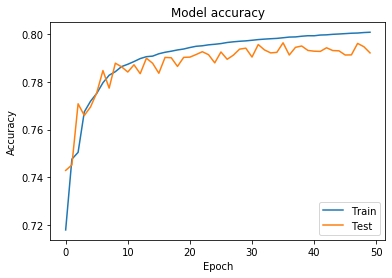

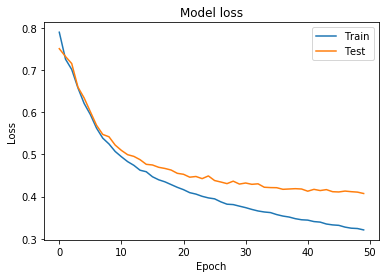

In [17]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc= 'lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Test average SSIM

In [0]:
def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[ i] for i in idx]
    data_shuffle_output = [data_output[ i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)


In [19]:
import time
from skimage.metrics import structural_similarity as ssim


Number = 1000

x_test_noisy , imgs_test = next_batch (Number , test_imgs, test_origins)

x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
imgs_test = imgs_test.reshape((-1,28,28,1))

c_1 = time.time()
recon_img = autoencoder.predict(x_test_noisy)
c_2 = time.time()

SSIM_test = []


for i in range(Number):
  s =ssim(recon_img[i],imgs_test[i], multichannel = True)
  SSIM_test.append(s)

print('reconstruction time = {}'.format(c_2-c_1))
print('average SSIM = {:.2f}'.format(sum(SSIM_test)/Number))
print('SSIM variance = {:.4f}'.format(np.var(SSIM_test)))

reconstruction time = 0.11213564872741699
average SSIM = 0.65
SSIM variance = 0.0203


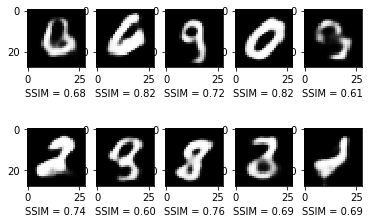

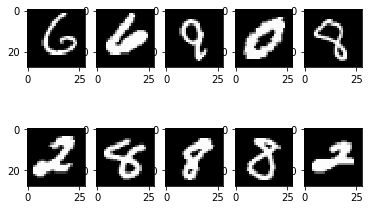

In [20]:
import matplotlib.pyplot as plt

images = decoded_imgs.reshape(-1,28,28)

for i in range(10 , 20):
  plt.subplot(2,5,i-10+1)
  plt.imshow(images[i], cmap = 'gray')
  s = ssim(images[i],test_origins[i].reshape(28,28),multichannel = True)
  plt.xlabel('SSIM = {:.2f}'.format(s))
plt.show()

for i in range(10,20):
  plt.subplot(2,5,i-10+1)
  plt.imshow(test_origins[i].reshape(28,28), cmap = 'gray')
plt.show()